# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-03-50/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4981 | MulticlassF1Score=0.0734
Batch-30 : CrossEntropyLoss=2.4863 | MulticlassF1Score=0.1616
Batch-45 : CrossEntropyLoss=2.4030 | MulticlassF1Score=0.2521
Batch-60 : CrossEntropyLoss=2.3939 | MulticlassF1Score=0.3229
Batch-75 : CrossEntropyLoss=2.3674 | MulticlassF1Score=0.3715
Batch-90 : CrossEntropyLoss=2.3892 | MulticlassF1Score=0.4080
Batch-105: CrossEntropyLoss=2.3602 | MulticlassF1Score=0.4347
Batch-120: CrossEntropyLoss=2.3628 | MulticlassF1Score=0.4523
Batch-135: CrossEntropyLoss=2.3507 | MulticlassF1Score=0.4717
Batch-150: CrossEntropyLoss=2.3569 | MulticlassF1Score=0.4915
Batch-165: CrossEntropyLoss=2.3615 | MulticlassF1Score=0.5084
Batch-180: CrossEntropyLoss=2.3576 | MulticlassF1Score=0.5221
Batch-195: CrossEntropyLoss=2.3396 | MulticlassF1Score=0.5341
Batch-210: CrossEntropyLoss=2.3488 | MulticlassF1Score=0.5435
Batch-225: CrossEntropyLoss=2.3438 | MulticlassF1Score=0.5535
Batch-226: CrossEntropyLoss=2.3482 | MulticlassF1Score=0.5540

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3424 | MulticlassF1Score=0.7091
Batch-30 : CrossEntropyLoss=2.3311 | MulticlassF1Score=0.7094
Batch-45 : CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7091
Batch-60 : CrossEntropyLoss=2.3578 | MulticlassF1Score=0.7087
Batch-63 : CrossEntropyLoss=2.3298 | MulticlassF1Score=0.7093

Training   : Mean CrossEntropyLoss = 2.3987 | Mean MulticlassF1Score = 0.3928
Validation : Mean CrossEntropyLoss = 2.3402 | Mean MulticlassF1Score = 0.7093

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.7118
Batch-30 : CrossEntropyLoss=2.3286 | MulticlassF1Score=0.7129
Batch-45 : CrossEntropyLoss=2.3384 | MulticlassF1Score=0.7162
Batch-60 : CrossEntropyLoss=2.3426 | MulticlassF1Score=0.7169
Batch-75 : CrossEntropyLoss=2.3292 | MulticlassF1Score=0.7167
Batch-90 : CrossEntropyLoss=2.3287 | MulticlassF1Score=0.7166
Batch-105: CrossEntropyLoss=2.3349 | MulticlassF1Score=0.7186
Batch-120: CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7185
Batch-135: CrossEntropyLoss=2.3364 | MulticlassF1Score=0.7186
Batch-150: CrossEntropyLoss=2.3547 | MulticlassF1Score=0.7184
Batch-165: CrossEntropyLoss=2.3349 | MulticlassF1Score=0.7194
Batch-180: CrossEntropyLoss=2.3344 | MulticlassF1Score=0.7197
Batch-195: CrossEntropyLoss=2.3334 | MulticlassF1Score=0.7201
Batch-210: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7200
Batch-225: CrossEntropyLoss=2.3428 | MulticlassF1Score=0.7201
Batch-226: CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7201

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3364 | MulticlassF1Score=0.7254
Batch-30 : CrossEntropyLoss=2.3340 | MulticlassF1Score=0.7238
Batch-45 : CrossEntropyLoss=2.3331 | MulticlassF1Score=0.7226
Batch-60 : CrossEntropyLoss=2.3351 | MulticlassF1Score=0.7234
Batch-63 : CrossEntropyLoss=2.3465 | MulticlassF1Score=0.7236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3351 | Mean MulticlassF1Score = 0.7175
Validation : Mean CrossEntropyLoss = 2.3339 | Mean MulticlassF1Score = 0.7246

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3272 | MulticlassF1Score=0.7331
Batch-30 : CrossEntropyLoss=2.3449 | MulticlassF1Score=0.7293
Batch-45 : CrossEntropyLoss=2.3394 | MulticlassF1Score=0.7287
Batch-60 : CrossEntropyLoss=2.3383 | MulticlassF1Score=0.7276
Batch-75 : CrossEntropyLoss=2.3291 | MulticlassF1Score=0.7263
Batch-90 : CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7259
Batch-105: CrossEntropyLoss=2.3358 | MulticlassF1Score=0.7260
Batch-120: CrossEntropyLoss=2.3390 | MulticlassF1Score=0.7259
Batch-135: CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7260
Batch-150: CrossEntropyLoss=2.3345 | MulticlassF1Score=0.7257
Batch-165: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.7258
Batch-180: CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7262
Batch-195: CrossEntropyLoss=2.3222 | MulticlassF1Score=0.7268
Batch-210: CrossEntropyLoss=2.3311 | MulticlassF1Score=0.7276
Batch-225: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7308
Batch-226: CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7310

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7809
Batch-30 : CrossEntropyLoss=2.3327 | MulticlassF1Score=0.7763
Batch-45 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7796
Batch-60 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7801
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.7810

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3313 | Mean MulticlassF1Score = 0.7277
Validation : Mean CrossEntropyLoss = 2.3168 | Mean MulticlassF1Score = 0.7802

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7836
Batch-30 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7979
Batch-45 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.7989
Batch-60 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8011
Batch-75 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8029
Batch-90 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8042
Batch-105: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8052
Batch-120: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8057
Batch-135: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8050
Batch-150: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8049
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8050
Batch-180: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8050
Batch-195: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8047
Batch-210: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8053
Batch-225: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8054
Batch-226: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8055

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.8045
Batch-30 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8071
Batch-45 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8052
Batch-60 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8061
Batch-63 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8066

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3083 | Mean MulticlassF1Score = 0.8016
Validation : Mean CrossEntropyLoss = 2.3079 | Mean MulticlassF1Score = 0.8051

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8113
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8149
Batch-45 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8137
Batch-60 : CrossEntropyLoss=2.3251 | MulticlassF1Score=0.8133
Batch-75 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.8134
Batch-90 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8138
Batch-105: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8129
Batch-120: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8127
Batch-135: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8152
Batch-150: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8171
Batch-165: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8180
Batch-180: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8187
Batch-195: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8191
Batch-210: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8200
Batch-225: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8203
Batch-226: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8203

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8293
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8278
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8268
Batch-60 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8264
Batch-63 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8154
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8268

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8381
Batch-30 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8321
Batch-45 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8304
Batch-60 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8316
Batch-75 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8316
Batch-90 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8325
Batch-105: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8323
Batch-120: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8319
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8320
Batch-150: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8317
Batch-165: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8318
Batch-180: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8323
Batch-195: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8325
Batch-210: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8329
Batch-225: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8326
Batch-226: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8325
Batch-30 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8275
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8262
Batch-60 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8270
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8325
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8287

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8357
Batch-30 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8351
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8349
Batch-75 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8364
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8363
Batch-105: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8358
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8351
Batch-135: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8351
Batch-150: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8349
Batch-165: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8344
Batch-180: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8342
Batch-195: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8344
Batch-210: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8341
Batch-225: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8339
Batch-226: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8287
Batch-30 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8282
Batch-45 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8275
Batch-60 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8282
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8285

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8353
Validation : Mean CrossEntropyLoss = 2.3007 | Mean MulticlassF1Score = 0.8295

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8384
Batch-30 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8345
Batch-45 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8354
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8350
Batch-75 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.8338
Batch-90 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8346
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8345
Batch-120: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8347
Batch-135: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8373
Batch-150: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8390
Batch-165: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8402
Batch-180: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8411
Batch-195: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8420
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8428
Batch-225: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8432
Batch-226: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8417
Batch-30 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8436
Batch-45 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8452
Batch-60 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8452
Batch-63 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8453

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8373
Validation : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8430

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8523
Batch-30 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8524
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8530
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8534
Batch-75 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8530
Batch-90 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8522
Batch-105: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8527
Batch-120: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8530
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8530
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8542
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8547
Batch-180: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8551
Batch-195: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8555
Batch-210: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8553
Batch-225: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8560
Batch-226: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8596
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8552
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8547
Batch-60 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8535

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2923 | Mean MulticlassF1Score = 0.8539
Validation : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8568

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8679
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8652
Batch-45 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8616
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8619
Batch-75 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8620
Batch-90 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8629
Batch-105: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8627
Batch-120: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8632
Batch-135: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8629
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8625
Batch-165: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8624
Batch-180: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8619
Batch-195: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8617
Batch-210: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8617
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8617
Batch-226: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8564
Batch-30 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8535
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8522
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8540

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2904 | Mean MulticlassF1Score = 0.8629
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8549

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8661
Batch-30 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8653
Batch-45 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8653
Batch-60 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8644
Batch-75 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8647
Batch-90 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8640
Batch-105: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8640
Batch-120: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8637
Batch-135: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8633
Batch-150: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8633
Batch-165: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8625
Batch-180: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8624
Batch-195: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8623
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8624
Batch-225: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8627
Batch-226: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8627

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8530
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8561
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8551
Batch-60 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8537
Batch-63 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8544

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2901 | Mean MulticlassF1Score = 0.8637
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8537

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8672
Batch-30 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8665
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8701
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8740
Batch-75 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8765
Batch-90 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8777
Batch-105: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8791
Batch-120: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8798
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8812
Batch-150: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8821
Batch-165: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8830
Batch-180: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8835
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8842
Batch-210: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8848
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8851
Batch-226: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8851

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8837
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8828
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8820
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8827

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8776
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8824

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8934
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8923
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8919
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8927
Batch-105: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8936
Batch-120: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8938
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8942
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8937
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8938
Batch-180: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8937
Batch-195: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8938
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8939
Batch-225: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8936
Batch-226: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8936

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8827
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8840
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8832
Batch-60 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8834
Batch-63 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8837

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8930
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8820

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8973
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8942
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8957
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8958
Batch-75 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8956
Batch-90 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8947
Batch-105: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8948
Batch-120: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8951
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8956
Batch-150: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8955
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8952
Batch-195: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8956
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8958
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8957
Batch-226: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8955

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8797
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8841
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8860
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8953
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8829

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9038
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8992
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8976
Batch-75 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8973
Batch-90 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8970
Batch-105: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8972
Batch-135: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8977
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8979
Batch-165: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8981
Batch-180: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8980
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8975
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8975
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8974
Batch-226: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8973

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8840
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8842
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8861
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8985
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8853

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8989
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.8999
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8992
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8996
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.8994
Batch-105: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9024
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9046
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9061
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9075
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9087
Batch-180: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9096
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9106
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9115
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9121
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9121

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9106
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9110
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9111
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9098
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9091

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9044
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9109

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9252
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9250
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9249
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9250
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9250
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9252
Batch-150: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9248
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9247
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9249
Batch-195: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9251
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9253
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9251
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9251

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9113
Batch-63 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.9114

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9249
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9132

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9271
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9271
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9272
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9277
Batch-120: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9281
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9278
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9282
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9281
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9283
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9284
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9282
Batch-225: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9283
Batch-226: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9282

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9131
Batch-30 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9137
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9272
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9154

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9289
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9289
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9297
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9295
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9288
Batch-135: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9288
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9292
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9294
Batch-180: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9297
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9292
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9293
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9293
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9293

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9139
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9130
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9131

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9291
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9144

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9327
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9311
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9311
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9315
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9310
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9308
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9307
Batch-165: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9300
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9299
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9299

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9103
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9120
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9317
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9111

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9310
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9322
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9314
Batch-75 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9313
Batch-105: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9314
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9313
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9315
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9316
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9310
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9306
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9306
Batch-225: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9306
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9306

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9140
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9144
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9146
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9146

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9310
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9152

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9354
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9325
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9319
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9321
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9311
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9310
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9310
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9309
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9313
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9313
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9312
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9311
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9311

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9145
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9141
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9158
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9149
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9146

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9325
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9154

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9302
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9312
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9310
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9314
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9310
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9313
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9315
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9317
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9319
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9318
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9316
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9315
Batch-226: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9142
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9163
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9140
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9143
Batch-63 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9144

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9160

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9290
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9303
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9305
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9302
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9310
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9313
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9317
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9316
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9317
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9319
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9317
Batch-225: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9318
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9133
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9146
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9144

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9140

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9331
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9330
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9331
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9338
Batch-135: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9338
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9343
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9345
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9344
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9344
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9346
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9343
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9342

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9333
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9199

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9341
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9354
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9358
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9359
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9359
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9356
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9188
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9194

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9352
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9184

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9373
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9375
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9377
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9369
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9364
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9199

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9382
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9381
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9380
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9379
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9382
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9193
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9207

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9378
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9197

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9395
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9393
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9336
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9345
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9344

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9395
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9327

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9565
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9555
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9564
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9571
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9574
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9578
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9582
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9584
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9585
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9585
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9587
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9588
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9590
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9590

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9409
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9410

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9577
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9402

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9576
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9580
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9594
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9589
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9589
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9601
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9605
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9607
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9607
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9604
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9604
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9603
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9604
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9603
Batch-226: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9604

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9420
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9417

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9595
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9397

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9614
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9610
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9609
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9610
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9609
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9611
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9614
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9618
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9621
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9619
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9618
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9618
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9433
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9431

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9613
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9425

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9637
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9637
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9641
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9637
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9636
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9637
Batch-210: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9636
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9636

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9464

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9625
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9644
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9647
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9643
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9641
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9644
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9450

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9646
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9642
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9639
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9443
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9441

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9643
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9444

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9642
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9654
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9652

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9455

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9453

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9464

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9473

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9459

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9445

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9476

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9450

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9439
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9659
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9658
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9660
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9444

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9479

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9655
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9479

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9705
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9498

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9521
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9499

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9505

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9714
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9720
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9501
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9499

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2514 | MulticlassF1Score=0.9744
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9727
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9731
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9730
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9729
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9725
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9724
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9726
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9722
Batch-195: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9723
Batch-210: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9723
Batch-225: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9725
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9500

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2560
Best CrossEntropyLoss training    : 2.2633
Best MulticlassF1Score validation : 0.9725
Best MulticlassF1Score validation : 0.9500
Training duration                 : 2.0177 minutes.
Training date                     : 2022-10-19 12:46:15.945484+08:00


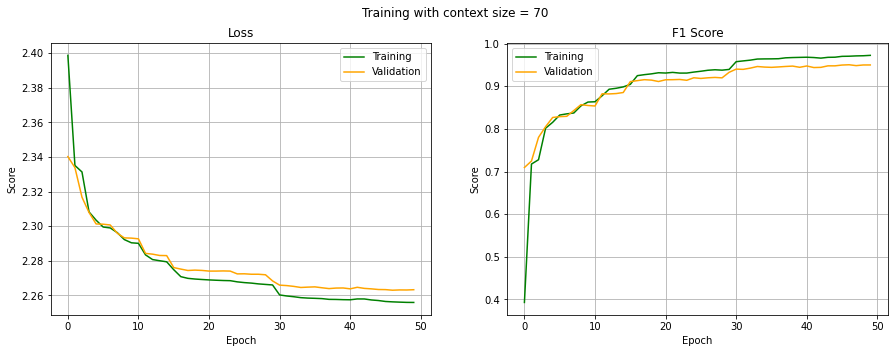

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9497, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9497, device='cuda:0'))

## Heatmap

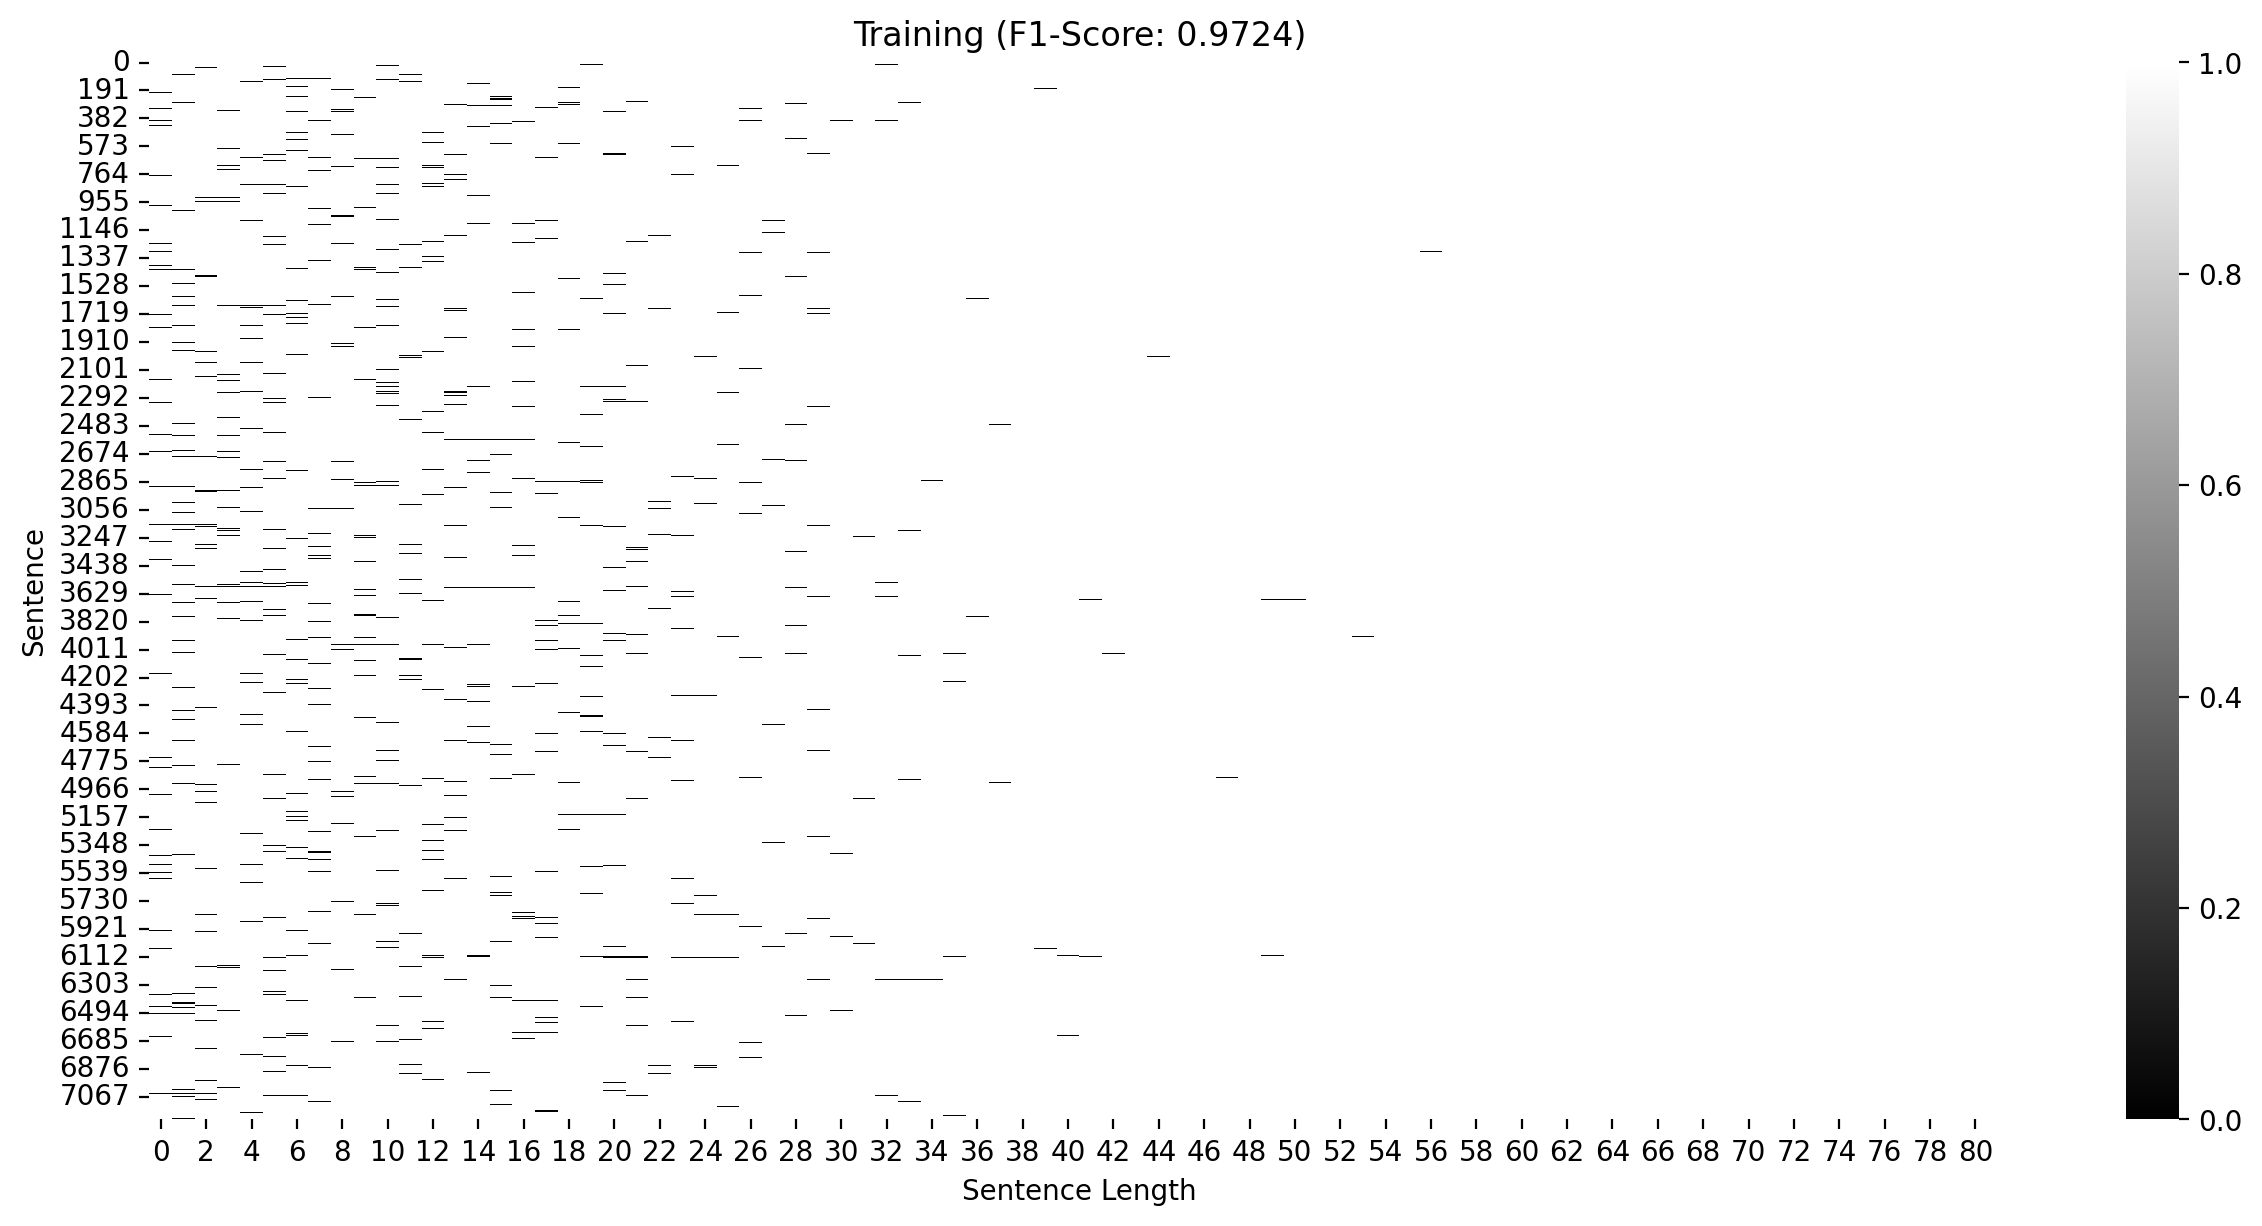

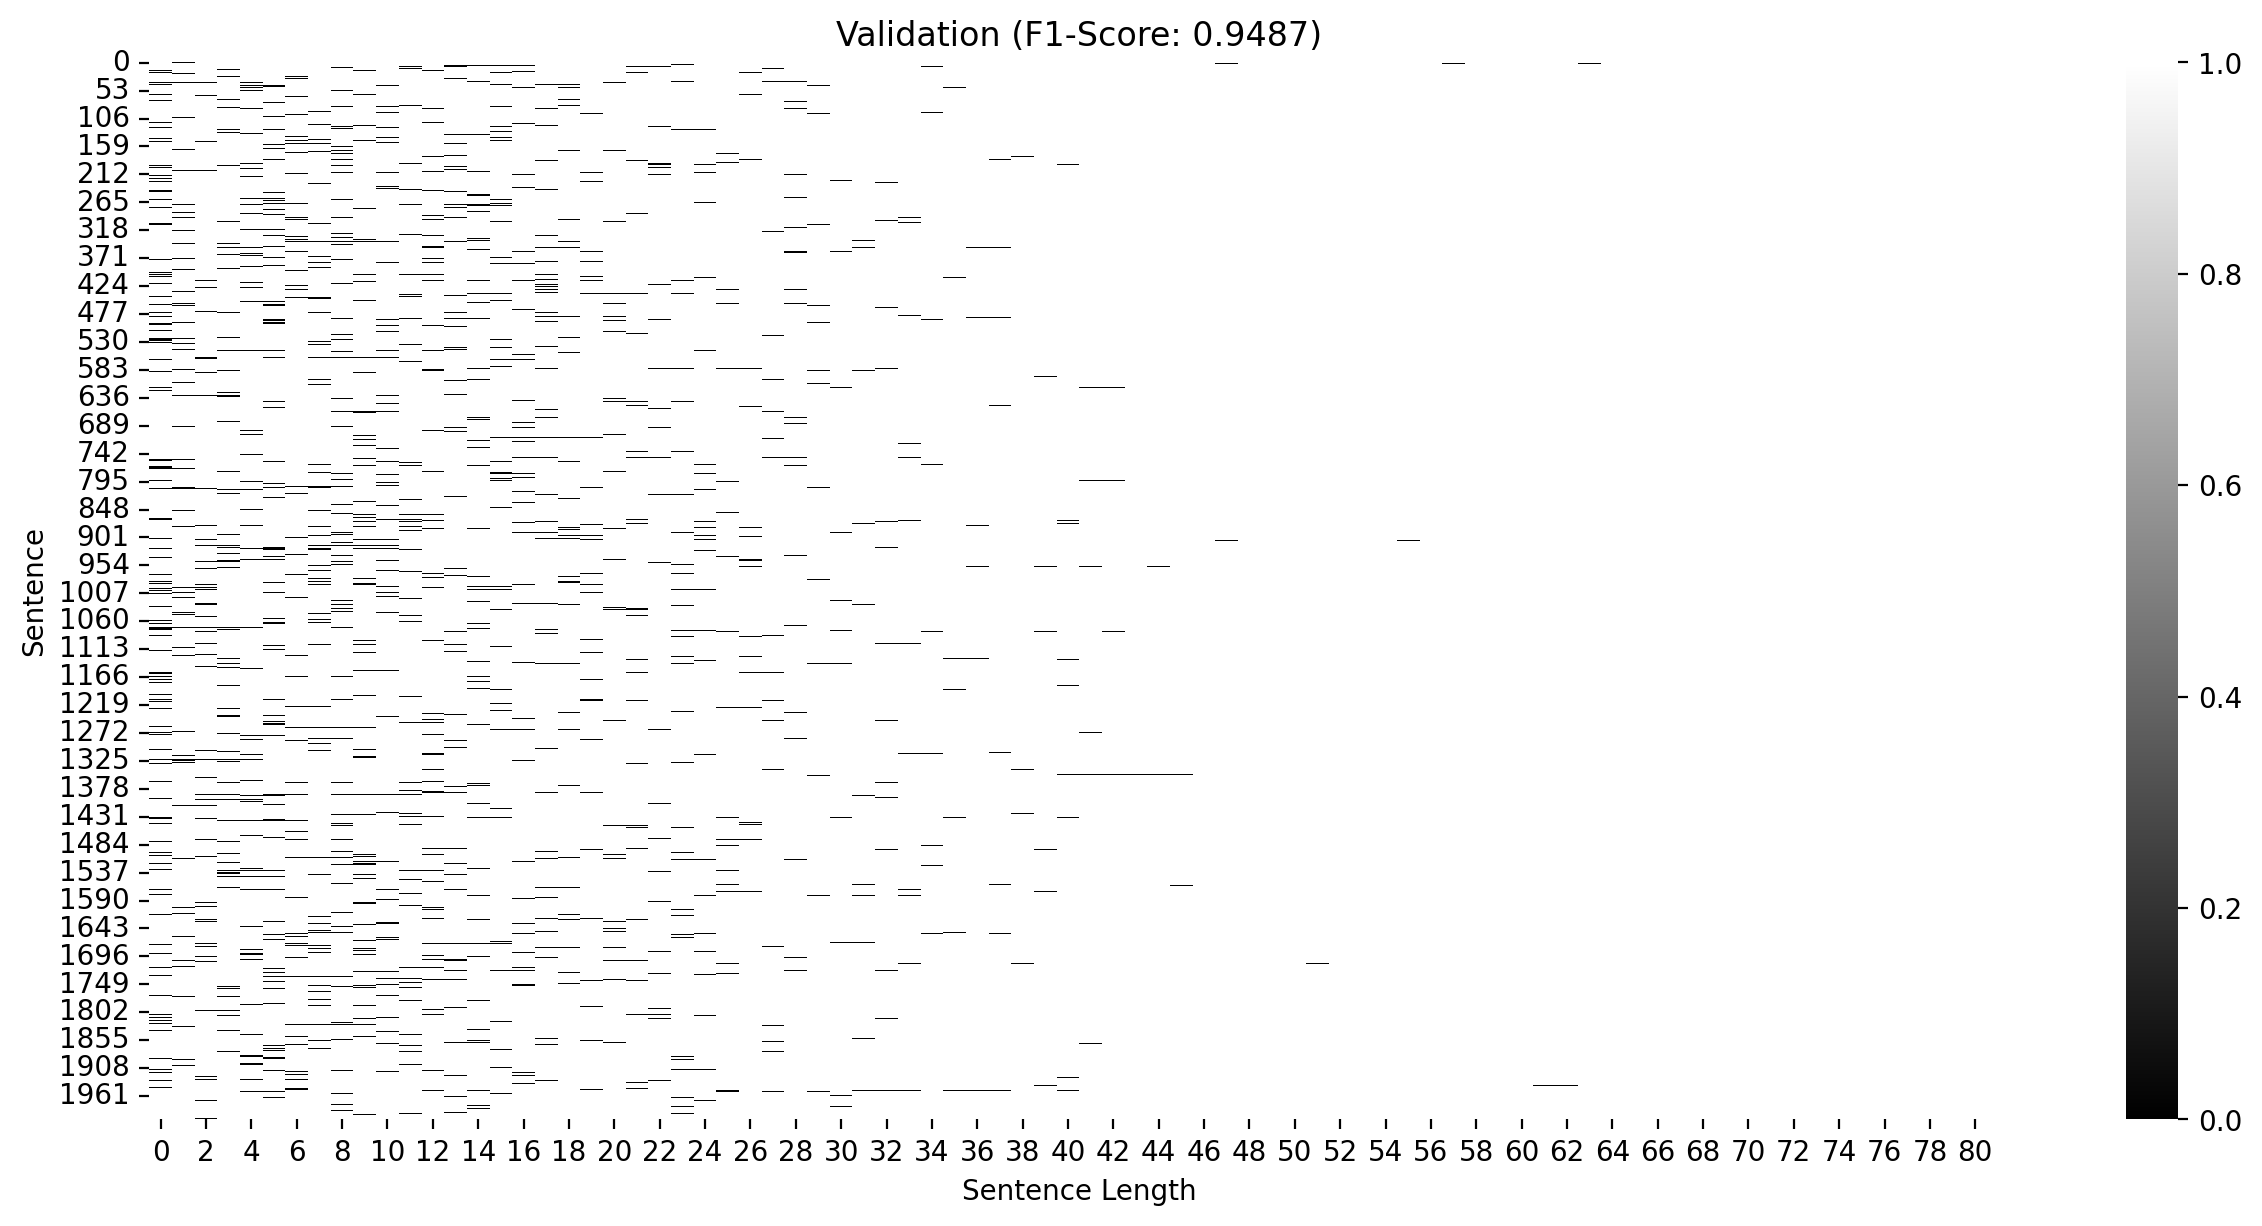

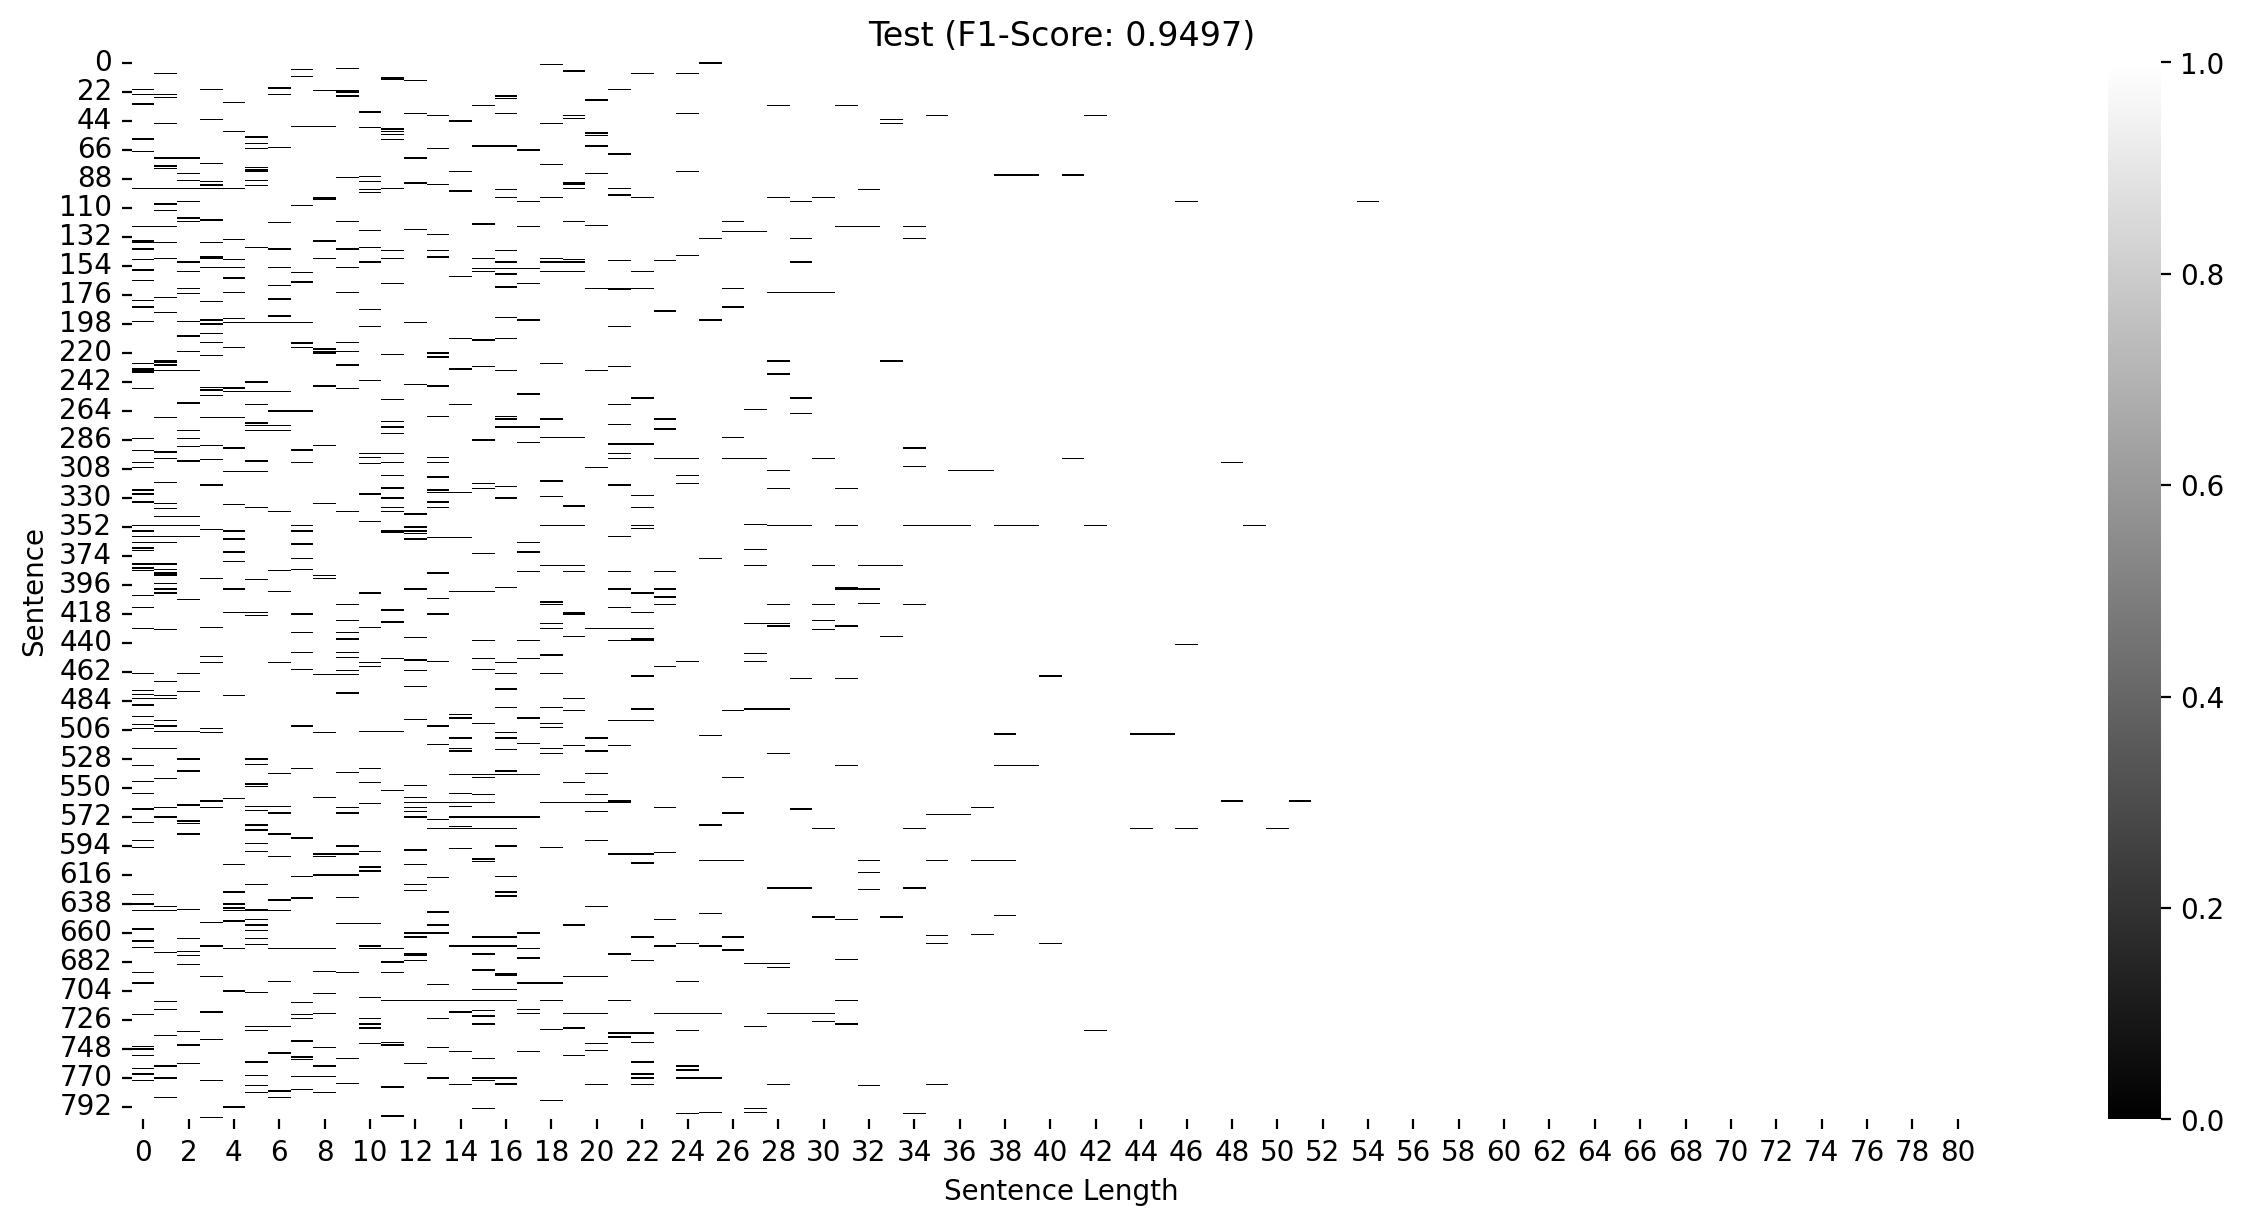

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


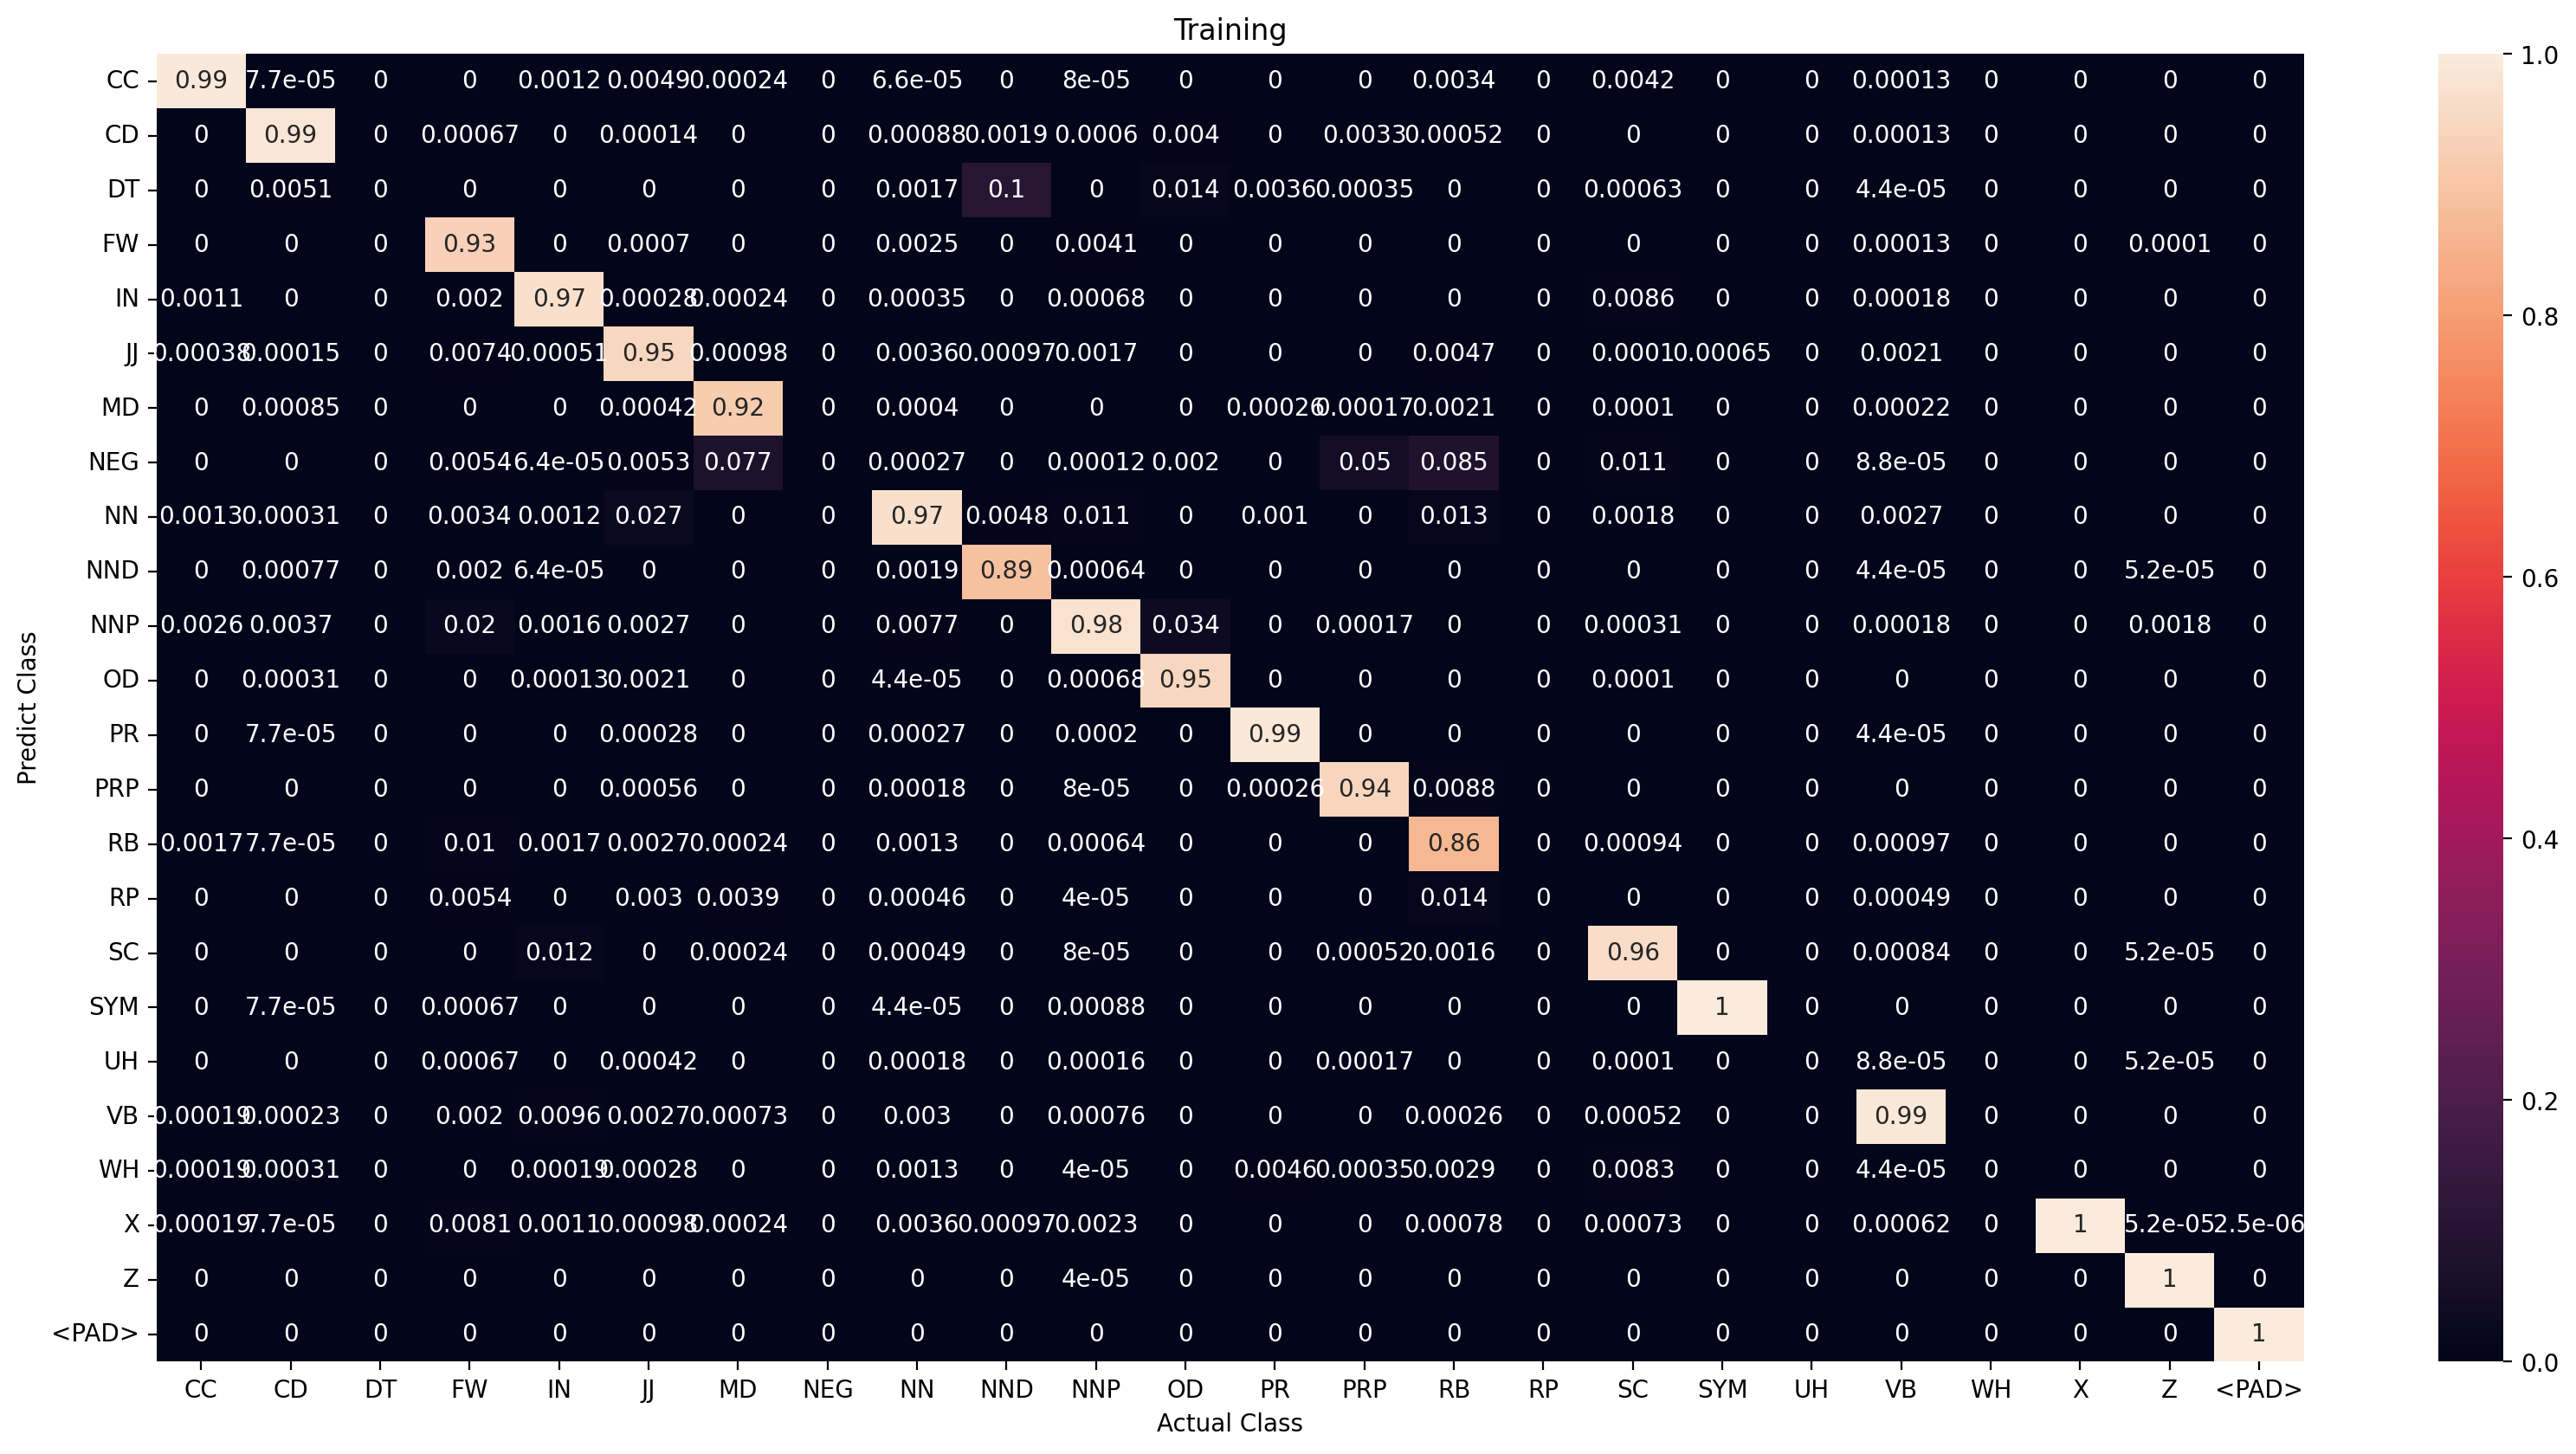

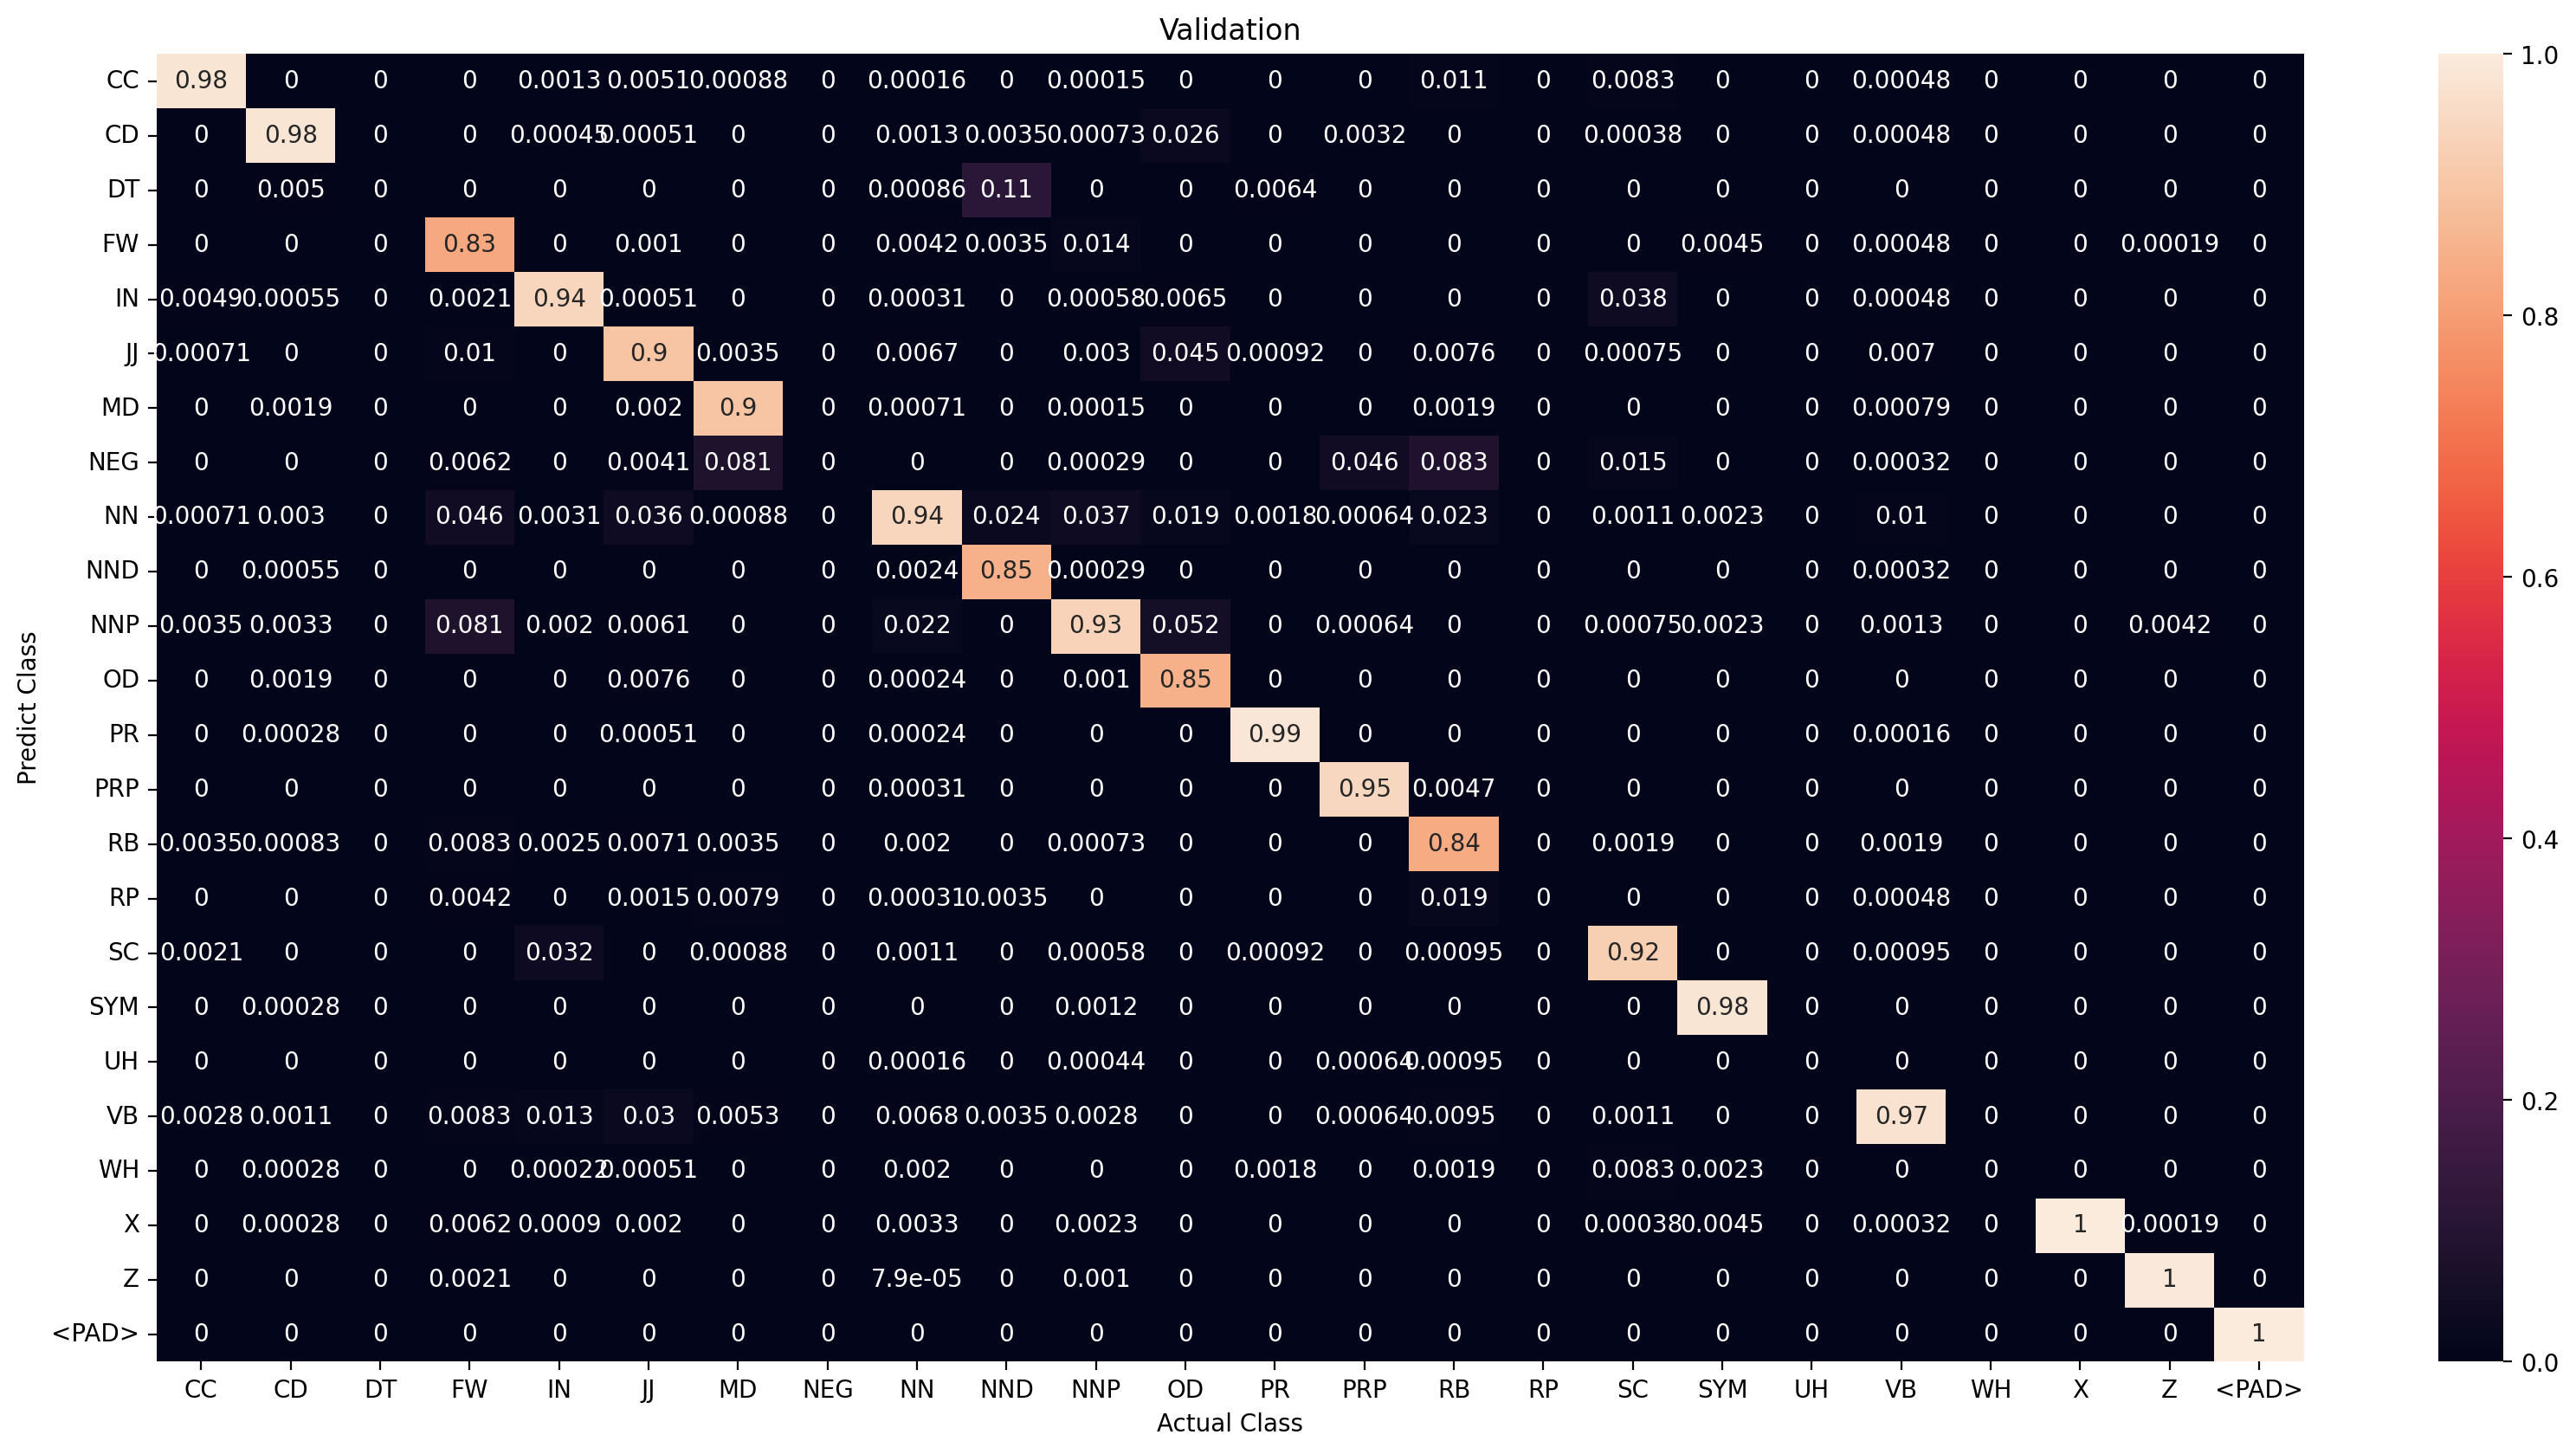

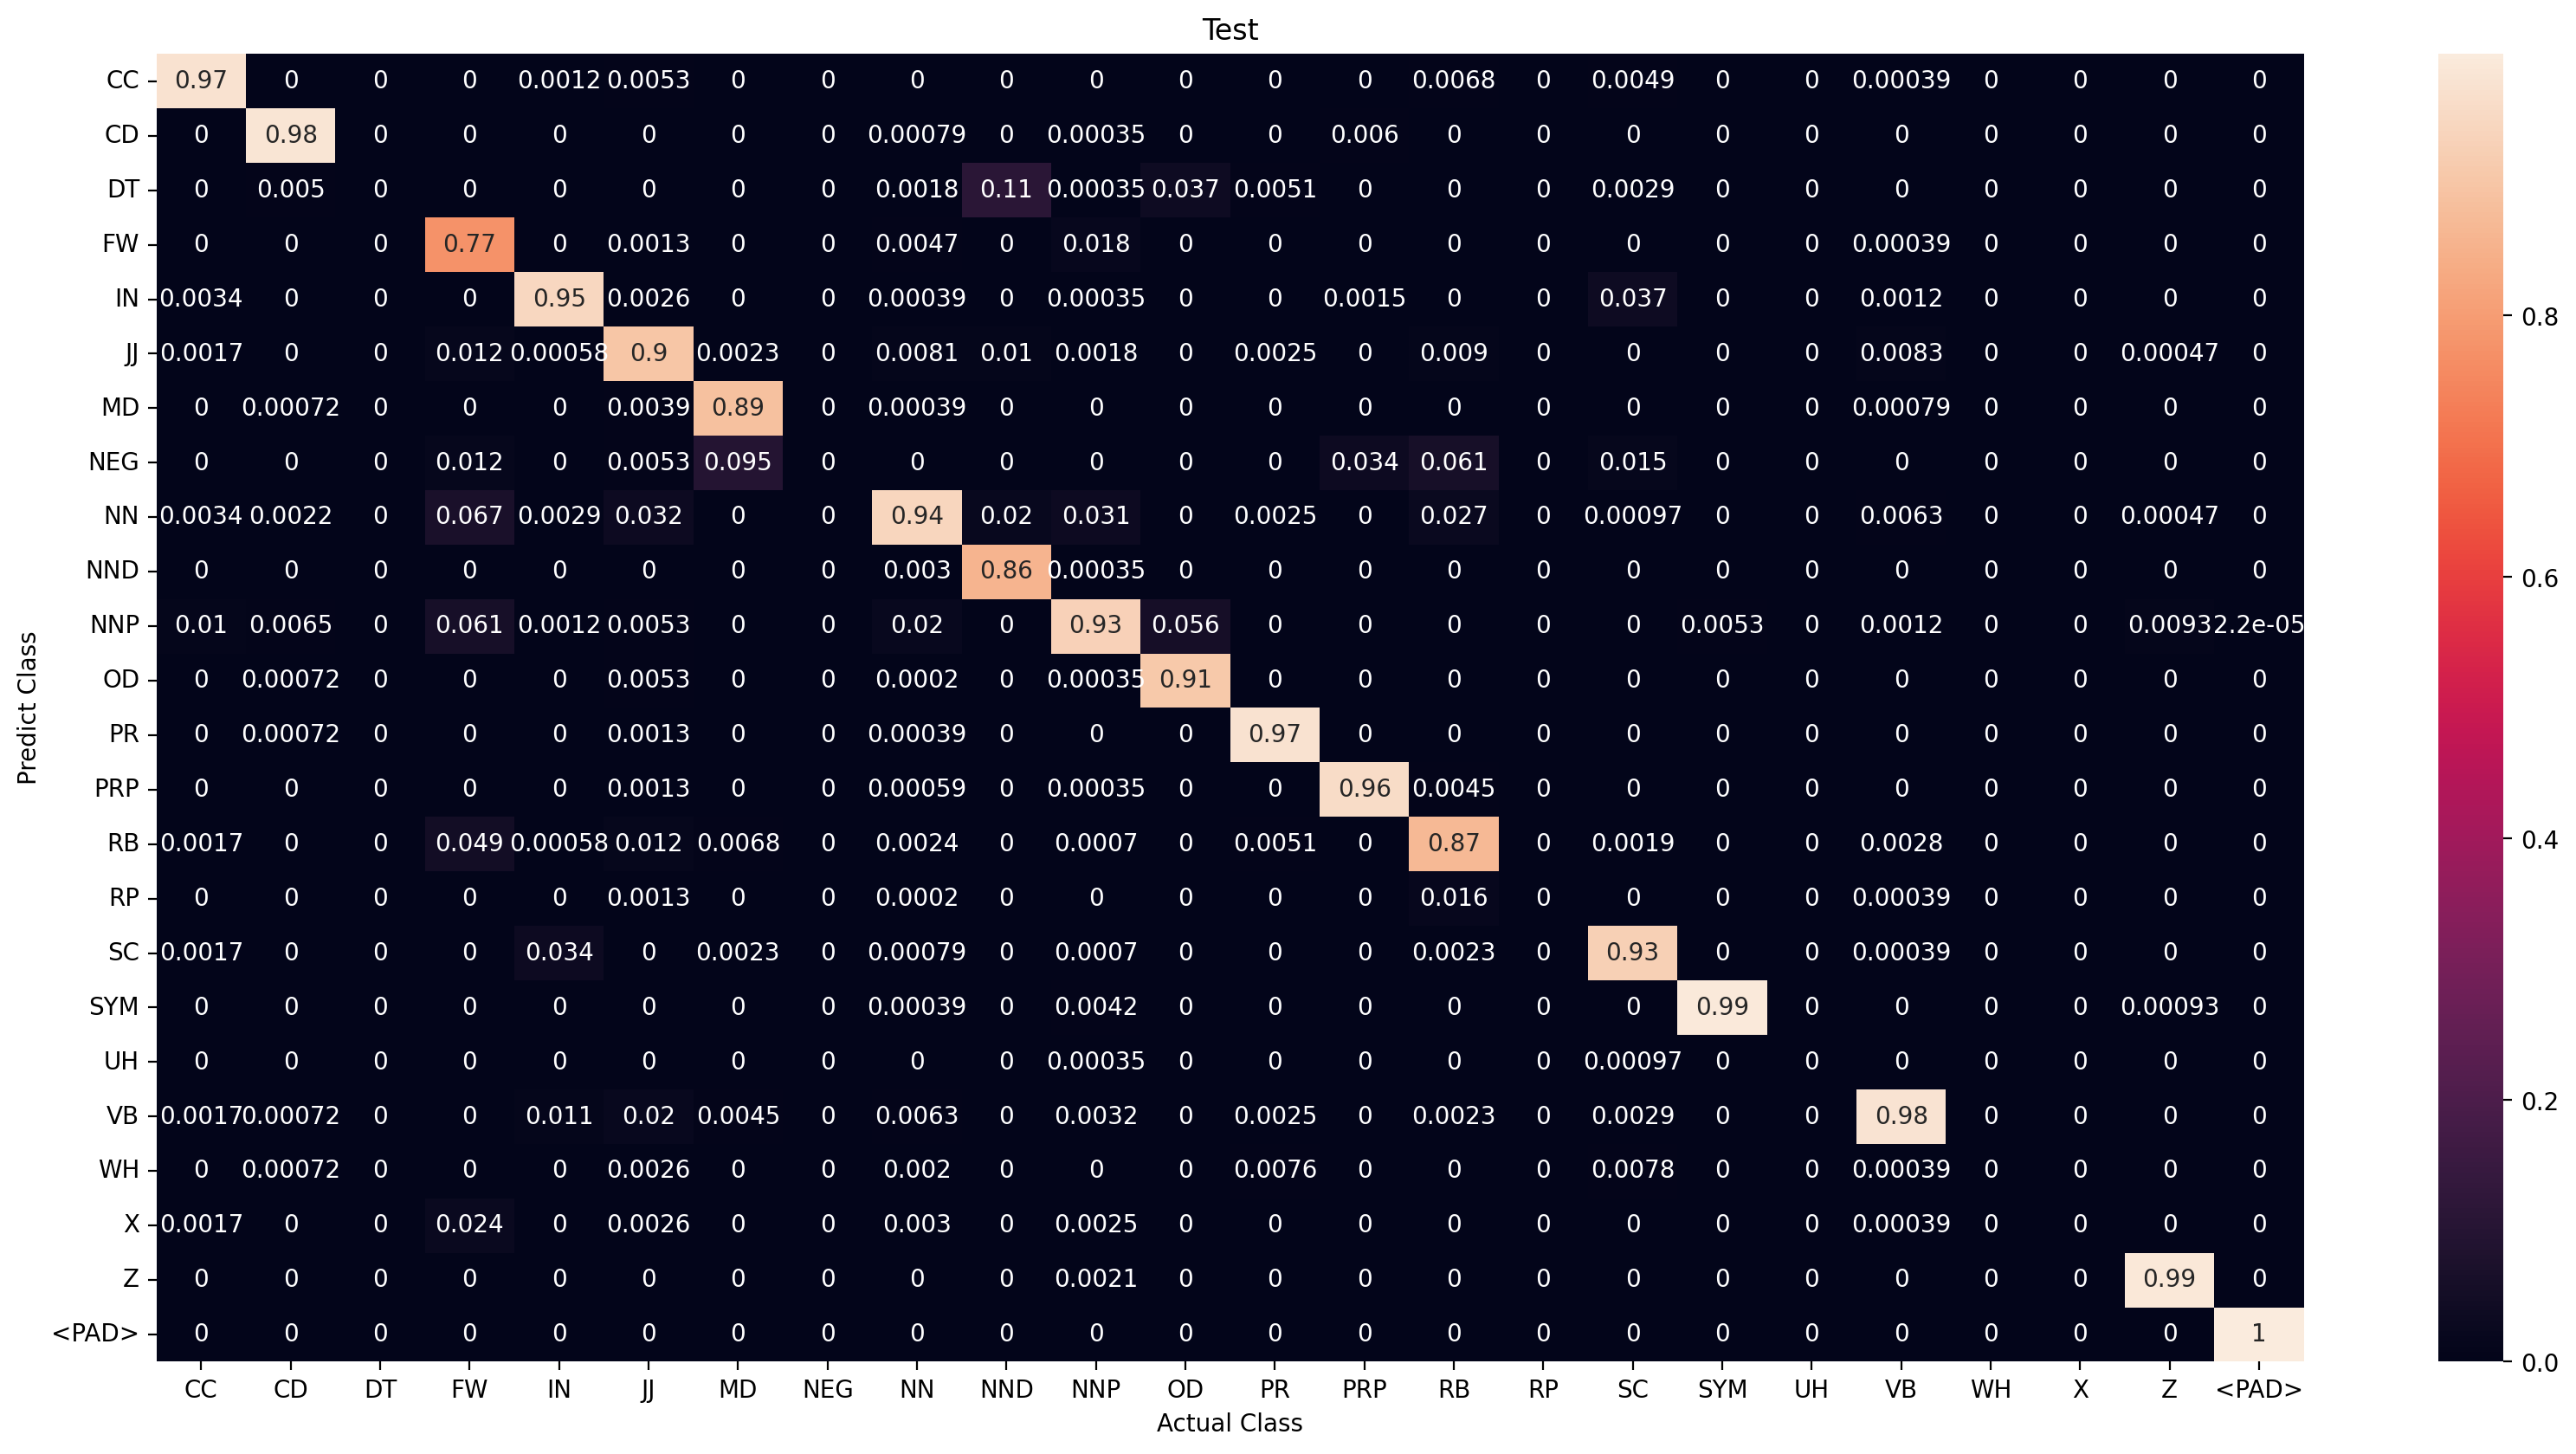

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5281       | CC    : 116      |
| CD    : 12862  | CD    : 12777      | CD    : 85       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1381       | FW    : 224      |
| IN    : 15290  | IN    : 15159      | IN    : 131      |
| JJ    : 7025   | JJ    : 6726       | JJ    : 299      |
| MD    : 3798   | MD    : 3750       | MD    : 48       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43840      | NN    : 632      |
| NND   : 1033   | NND   : 917        | NND   : 116      |
| NNP   : 25007  | NNP   : 24466      | NNP   : 541      |
| OD    : 519    | OD    : 478        | OD    : 41       |
| PR    : 3880   | PR    : 3859       | PR    : 21       |
| PRP   : 5449   | PRP   : 5400       | PRP   : 49       |
| RB    : 3502   | RB    : 3323       | RB    : 179      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11311
Wrong prediction            : 660
Percentage correct oov pred : 94.48667613399047

Validation
Number OOV token            : 3190
Correct prediction          : 2858
Wrong prediction            : 332
Percentage correct oov pred : 89.59247648902821

Test
Number OOV token            : 1401
Correct prediction          : 1256
Wrong prediction            : 145
Percentage correct oov pred : 89.65024982155603



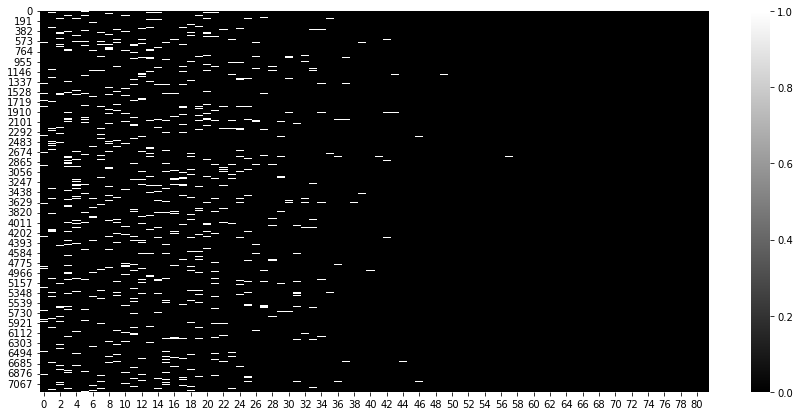

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

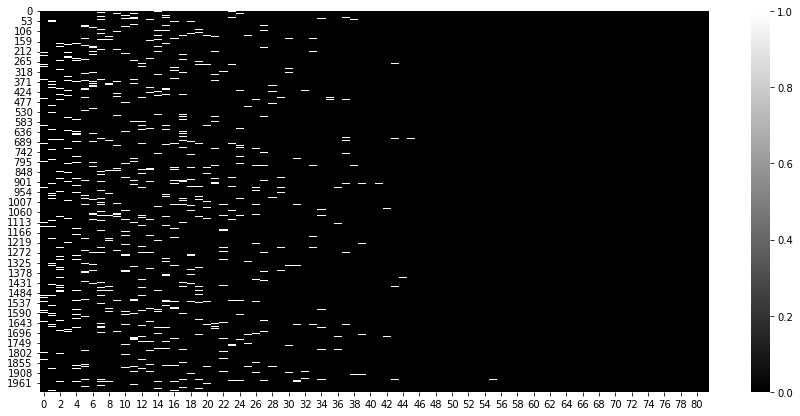

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

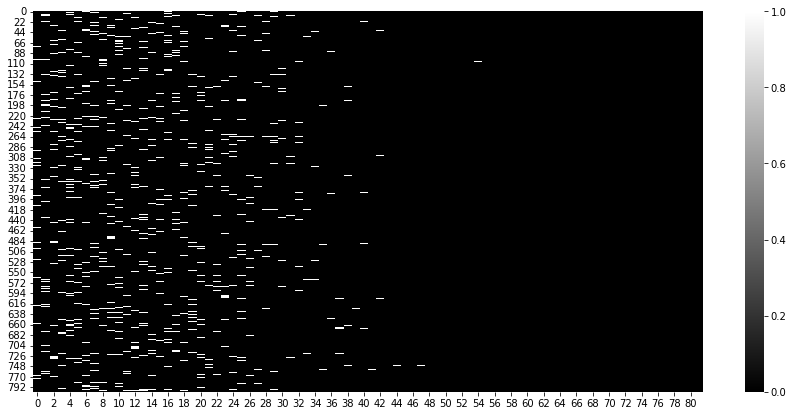

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);